In [114]:
#imports only
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV,GridSearchCV
from scipy import stats
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.discriminant_analysis as skl_da
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score

In [115]:
file_path = 'siren_data_train.csv'
data = pd.read_csv(file_path)

data_copy = data.copy()

data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55


In [116]:
data.describe()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age
count,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5.710000e+03,5.710000e+03,5710.000000,5710.000000,5710.000000,5710.000000,5710.000000
mean,1888.705954,1.797385e+06,8.283496e+06,1.751993,0.760070,0.248687,1.796497e+06,8.283723e+06,0.190893,0.094046,0.006130,0.023643,50.635902
std,1320.046217,2.783430e+05,5.363099e+05,106.216736,0.427078,0.432290,2.789790e+05,5.369782e+05,0.393039,0.291918,0.078058,0.151947,18.630865
min,1.000000,1.244070e+06,7.430582e+06,-179.786267,0.000000,0.000000,1.244893e+06,7.432236e+06,0.000000,0.000000,0.000000,0.000000,18.000000
25%,538.000000,1.535191e+06,7.919606e+06,-90.278514,1.000000,0.000000,1.529848e+06,7.919276e+06,0.000000,0.000000,0.000000,0.000000,35.000000
50%,1901.000000,1.895376e+06,8.251327e+06,2.313685,1.000000,0.000000,1.891302e+06,8.251345e+06,0.000000,0.000000,0.000000,0.000000,50.000000
75%,2821.000000,2.003408e+06,8.368423e+06,95.330994,1.000000,0.000000,2.003743e+06,8.368852e+06,0.000000,0.000000,0.000000,0.000000,66.000000
max,4150.000000,2.686771e+06,1.040622e+07,179.992043,1.000000,1.000000,2.686256e+06,1.042743e+07,1.000000,1.000000,1.000000,1.000000,88.000000


# Create new features - distance, age group and distance group

### Create age group

#### Created new age buckets based on:
https://www.nidcd.nih.gov/health/statistics/hearing-loss-increases-with-age

In [117]:

#new bins based on hearing with age
new_age_bins = [0, 40, 50, 60, 70, float('inf')]
new_age_labels = ['0-39', '40-49', '50-59', '60-69', '70+']

# Create age groups column with new bins
data['age_group1'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)

#new age groups, only three buckets. Does it perform better to have fewer buckets?
#create new age_groups--------
#new bins based on hearing with age
new_age_bins = [0, 30, 60, float('inf')]
new_age_labels = ['Young', 'Middle-aged', 'Elderly']

# Create age groups column with new bins
data['age_group2'] = pd.cut(data['age'], bins=new_age_bins, labels=new_age_labels, right=False)



In [118]:
data

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,asleep,no_windows,age,age_group1,age_group2
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,0,0,59,50-59,Middle-aged
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,0,0,29,0-39,Young
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,0,0,32,0-39,Middle-aged
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,0,0,36,0-39,Middle-aged
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,0,0,55,50-59,Middle-aged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,5,2.008871e+06,8.255775e+06,-176.234663,1,0,2009140.0,8255793,0,0,0,0,29,0-39,Young
5706,4069,1.981871e+06,8.270452e+06,45.691415,1,0,1981119.0,8269682,0,0,0,0,49,40-49,Middle-aged
5707,2170,1.463760e+06,8.074997e+06,-175.473118,1,0,1464308.0,8075040,0,0,0,0,62,60-69,Elderly
5708,1591,1.479843e+06,7.526377e+06,142.958054,1,0,1480125.0,7526164,0,0,0,0,37,0-39,Middle-aged


### Create distance

In [119]:
#add distance to horn
# Calculate Euclidean distance between person and nearest horn
data['dist'] = np.sqrt((data['xcoor'] - data['near_x'])**2 + (data['ycoor'] - data['near_y'])**2)


### Create distance group

In [120]:

# Add distance groups
# Create bins for distance ranging from 0 to 3000 with a step size of 100
step_size = 500
distance_bins = np.arange(0, 3100, step_size)

# Create labels for distance bins
distance_labels = [f'{i}-{i+step_size}' for i in range(0, 3000, step_size)]
# Append a bin edge for values greater than 3000
distance_bins = np.append(distance_bins, np.inf)
distance_labels.append('>3000')

# Assign each distance value to a corresponding bin
data['distance_groups'] = pd.cut(data['dist'], bins=distance_bins, labels=distance_labels, right=False)

In [121]:
## Create new combined features of noise and in_vehicle

In [122]:
# Create new combined features of noise and in_vehicle
# Assuming 'data' is your DataFrame containing the 'noise' and 'in_vehicle' features
data['noise_in_vehicle'] = ((data['noise'] == 1) & (data['in_vehicle'] == 1)).astype(int)
data['noise_not_in_vehicle'] = ((data['noise'] == 1) & (data['in_vehicle'] == 0)).astype(int)
data['not_noise_in_vehicle'] = ((data['noise'] == 0) & (data['in_vehicle'] == 1)).astype(int)
data['not_noise_not_in_vehicle'] = ((data['noise'] == 0) & (data['in_vehicle'] == 0)).astype(int)


### Check data

In [123]:
data.head()

,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,noise,in_vehicle,...,no_windows,age,age_group1,age_group2,dist,distance_groups,noise_in_vehicle,noise_not_in_vehicle,not_noise_in_vehicle,not_noise_not_in_vehicle
0,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,0,0,...,0,59,50-59,Middle-aged,901.283517,500-1000,0,0,0,1
1,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,0,0,...,0,29,0-39,Young,972.006260,500-1000,0,0,0,1
2,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,0,0,...,0,32,0-39,Middle-aged,872.340924,500-1000,0,0,0,1
3,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,0,0,...,0,36,0-39,Middle-aged,257.804449,0-500,0,0,0,1
4,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,0,0,...,0,55,50-59,Middle-aged,529.686791,500-1000,0,0,0,1


# Generate dummies for newly created categorical data but keep original columns for the plots later

In [124]:
dummies = pd.get_dummies(data, columns=["age_group1", "age_group2", "distance_groups"])
keep_these_original_columns_for_plots = data[["distance_groups", "age_group1"]]
data = pd.concat([keep_these_original_columns_for_plots, dummies], axis=1)
data_copy = data.copy()


In [125]:
data.head()

,distance_groups,age_group1,near_fid,near_x,near_y,near_angle,heard,building,xcoor,ycoor,...,age_group2_Young,age_group2_Middle-aged,age_group2_Elderly,distance_groups_0-500,distance_groups_500-1000,distance_groups_1000-1500,distance_groups_1500-2000,distance_groups_2000-2500,distance_groups_2500-3000,distance_groups_>3000
0,500-1000,50-59,2712,1.998301e+06,9.011692e+06,-171.588672,1,0,1999193.0,9011824,...,0,1,0,0,1,0,0,0,0,0
1,500-1000,0-39,2721,1.928907e+06,8.954624e+06,-51.208102,1,0,1928298.0,8955382,...,1,0,0,0,1,0,0,0,0,0
2,500-1000,0-39,297,2.026384e+06,8.256164e+06,39.018754,1,0,2025706.0,8255615,...,0,1,0,0,1,0,0,0,0,0
3,0-500,0-39,739,1.743184e+06,8.052652e+06,15.046022,1,0,1742935.0,8052585,...,0,1,0,1,0,0,0,0,0,0
4,500-1000,50-59,1852,1.350375e+06,7.909850e+06,144.603170,1,0,1350807.0,7909543,...,0,1,0,0,1,0,0,0,0,0


# Generating samples, create train and test

In [126]:
#random sampling
def split_train_test(data, test_ratio, random_state): 
    shuffled_indices = np.random.permutation(len(data)) if random_state is None else np.random.RandomState(random_state).permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#stratified sampling, where we create a sample that takes the distribution of age into account
def stratified_sampling(data, test_ratio, important_data_column):
    split = StratifiedShuffleSplit(n_splits=1, test_size = test_ratio, random_state=42)
    for train_index, test_index in split.split(data, important_data_column):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return strat_train_set, strat_test_set


#create samples
#train, test = stratified_sampling(data, 0.2, data["age"])
train, test = split_train_test(data, 0.2, random_state=42)

#print(len(test_set))
#print(len(train_set))

# Set X_train, X_test, y_train and y_test

In [127]:
#drop categorical values 
train = train.drop(columns=["distance_groups", "age_group1"], axis=1)
test = test.drop(columns=["distance_groups", "age_group1"], axis=1)

In [128]:
#right now we have all features, pls change

X_train = train.drop(columns=['heard'])
y_train = train['heard']

# Extract features and target for testing set
X_test = test.drop(columns=['heard'])
y_test = test['heard']


In [129]:
train.columns

Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'heard', 'building',
       'xcoor', 'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'age',
       'dist', 'noise_in_vehicle', 'noise_not_in_vehicle',
       'not_noise_in_vehicle', 'not_noise_not_in_vehicle', 'age_group1_0-39',
       'age_group1_40-49', 'age_group1_50-59', 'age_group1_60-69',
       'age_group1_70+', 'age_group2_Young', 'age_group2_Middle-aged',
       'age_group2_Elderly', 'distance_groups_0-500',
       'distance_groups_500-1000', 'distance_groups_1000-1500',
       'distance_groups_1500-2000', 'distance_groups_2000-2500',
       'distance_groups_2500-3000', 'distance_groups_>3000'],
      dtype='object')

# (i) Does the distance to the nearest horn affect whether a person hears the siren or not?

In [130]:
data.columns

Index(['distance_groups', 'age_group1', 'near_fid', 'near_x', 'near_y',
       'near_angle', 'heard', 'building', 'xcoor', 'ycoor', 'noise',
       'in_vehicle', 'asleep', 'no_windows', 'age', 'dist', 'noise_in_vehicle',
       'noise_not_in_vehicle', 'not_noise_in_vehicle',
       'not_noise_not_in_vehicle', 'age_group1_0-39', 'age_group1_40-49',
       'age_group1_50-59', 'age_group1_60-69', 'age_group1_70+',
       'age_group2_Young', 'age_group2_Middle-aged', 'age_group2_Elderly',
       'distance_groups_0-500', 'distance_groups_500-1000',
       'distance_groups_1000-1500', 'distance_groups_1500-2000',
       'distance_groups_2000-2500', 'distance_groups_2500-3000',
       'distance_groups_>3000'],
      dtype='object')

Text(0, 0.5, 'The procent hearing (%)')

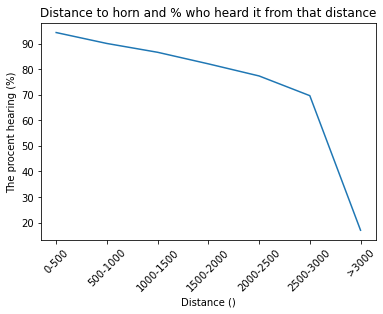

In [19]:
dist_num = data.pivot_table(index = ['distance_groups'], columns= 'heard', aggfunc='size')

dist_num[1] = dist_num[1].fillna(0)
dist_num[0] = dist_num[0].fillna(0)
dist_num_1 = np.array(dist_num[1])
dist_num_0 = np.array(dist_num[0])

dist_procent = (dist_num_1)/(dist_num_1+dist_num_0)*100

index_dist = np.array(dist_num.index)


plt.plot(index_dist, dist_procent)
plt.xlabel('Distance ()')
plt.title("Distance to horn and % who heard it from that distance")
plt.xticks(rotation=45)
plt.ylabel('The procent hearing (%)')

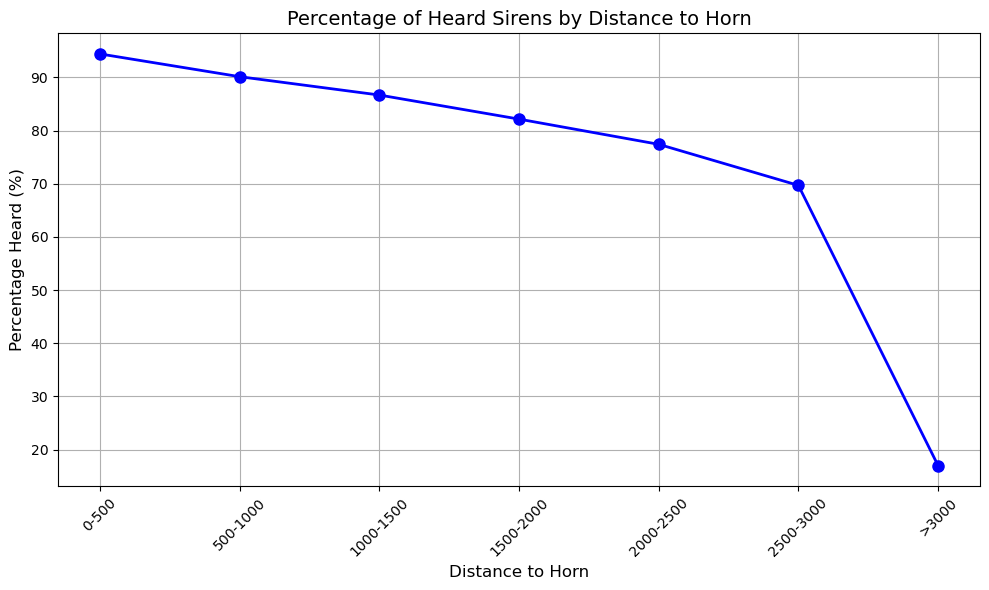

In [132]:
# Calculate the number of instances for each distance group and hearing status
dist_num = data.pivot_table(index='distance_groups', columns='heard', aggfunc='size')

# Fill missing values with 0
dist_num[1] = dist_num[1].fillna(0)
dist_num[0] = dist_num[0].fillna(0)

# Convert the counts to numpy arrays
dist_num_1 = np.array(dist_num[1])
dist_num_0 = np.array(dist_num[0])

# Calculate the percentage of instances where the siren was heard for each distance group
dist_procent = (dist_num_1) / (dist_num_1 + dist_num_0) * 100

# Plotting
index_dist = np.array(dist_num.index)
plt.figure(figsize=(10, 6))
plt.plot(index_dist, dist_procent, color='blue', linestyle='-', marker='o', markersize=8, linewidth=2)

# Adding labels and formatting
plt.xlabel('Distance to Horn', fontsize=12)
plt.ylabel('Percentage Heard (%)', fontsize=12)
plt.title('Percentage of Heard Sirens by Distance to Horn', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Is there a statistical difference between those that heard the signal and those that didn't given the distance?

In [133]:
import numpy as np
from scipy.stats import ttest_ind

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['dist']
not_heard_distances = data[data['heard'] == 0]['dist']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean distances between the heard and not heard groups.")


T-statistic: -51.7056653375075
P-value: 0.0
Reject null hypothesis: There is a significant difference in mean distances between the heard and not heard groups.


# (ii) Are the people who hear the siren younger than the people who do not hear it?

Text(0, 0.5, 'The procent hearing (%)')

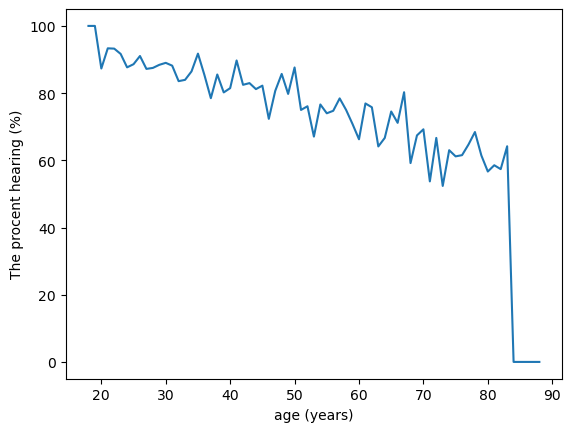

In [134]:
#The relationship between age and hearing
age_num = data_copy.pivot_table(index = ['age'], columns= 'heard', aggfunc='size')

age_num[1] = age_num[1].fillna(0)
age_num[0] = age_num[0].fillna(0)
age_num_1 = np.array(age_num[1])
age_num_0 = np.array(age_num[0])

age_procent = (age_num_1)/(age_num_1+age_num_0)*100 #procent som hör per åldersgrupp

index_age = np.array(age_num.index)

plt.plot(index_age, age_procent)
plt.xlabel('age (years)')
plt.ylabel('The procent hearing (%)')



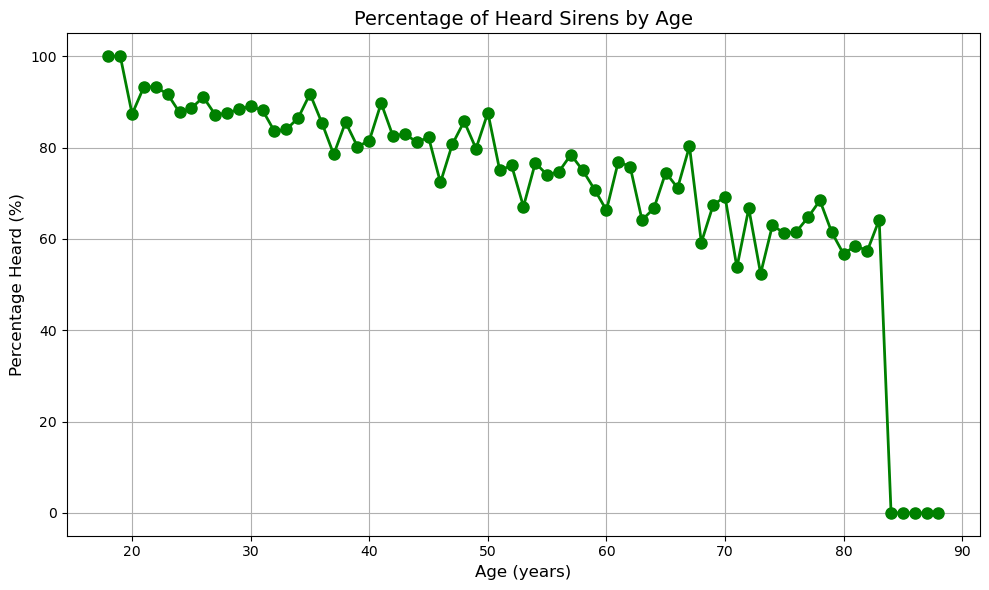

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the number of instances for each age group and hearing status
age_num = data_copy.pivot_table(index='age', columns='heard', aggfunc='size')

# Fill missing values with 0
age_num[1] = age_num[1].fillna(0)
age_num[0] = age_num[0].fillna(0)

# Convert the counts to numpy arrays
age_num_1 = np.array(age_num[1])
age_num_0 = np.array(age_num[0])

# Calculate the percentage of instances where the siren was heard for each age group
age_percentage = (age_num_1) / (age_num_1 + age_num_0) * 100

# Plotting
index_age = np.array(age_num.index)
plt.figure(figsize=(10, 6))
plt.plot(index_age, age_percentage, color='green', linestyle='-', marker='o', markersize=8, linewidth=2)

# Adding labels and formatting
plt.xlabel('Age (years)', fontsize=12)
plt.ylabel('Percentage Heard (%)', fontsize=12)
plt.title('Percentage of Heard Sirens by Age', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [138]:
import numpy as np
from scipy.stats import ttest_ind

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['age']
not_heard_distances = data[data['heard'] == 0]['age']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean ages between the heard and not heard groups.")


T-statistic: -22.79964593973161
P-value: 3.3998771811922806e-110
Reject null hypothesis: There is a significant difference in mean ages between the heard and not heard groups.


# (iii) Does the direction towards the nearest horn affect whether a person hears the siren or not?

Text(0, 0.5, 'The procent hearing (%)')

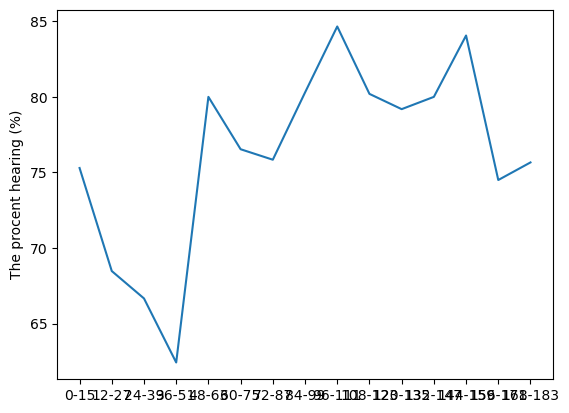

In [139]:
# Create bins for angle ranging from 0 to 2000 with a step size of 100
angle_bins = np.arange(0, 181, 12)

# Create labels for angle bins
angle_labels = [f'{i}-{i+15}' for i in range(0, 180, 12)]

# Assign each angle value to a corresponding bin
data['ange_span'] = pd.cut(data['near_angle'], bins=angle_bins, labels=angle_labels, right=False)

angle_num = data.pivot_table(index = ['ange_span'], columns= 'heard', aggfunc='size')

angle_num_1 = np.array(angle_num[1])
angle_num_0 = np.array(angle_num[0])

angle_procent = (angle_num_1 )/(angle_num_1 +angle_num_0)*100 #procent som hör

index_angle = np.array(angle_num.index)

plt.plot(index_angle, angle_procent)
plt.xlabel('')
plt.ylabel('The procent hearing (%)')


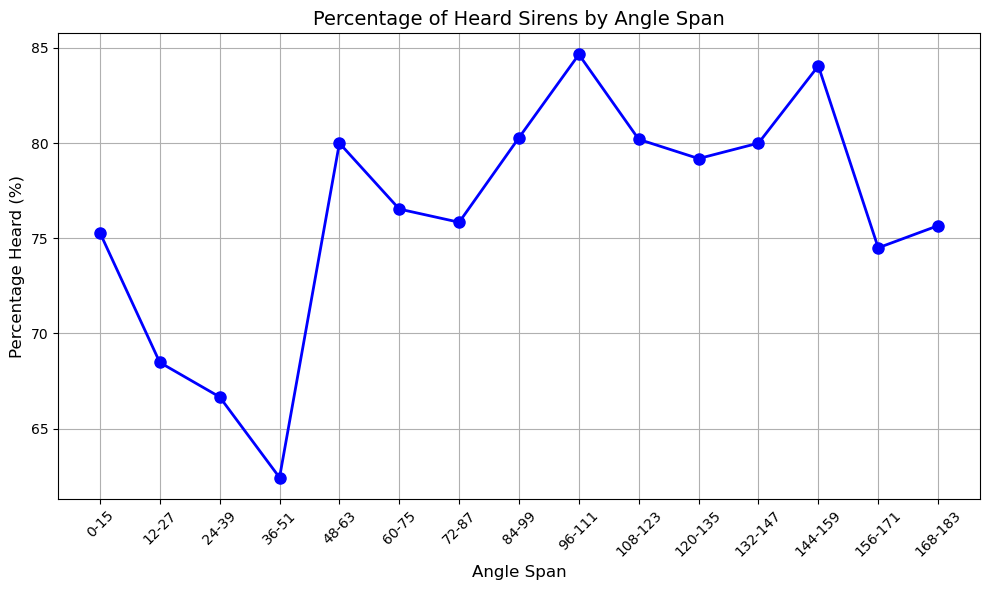

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create bins for angle ranging from 0 to 2000 with a step size of 100
angle_bins = np.arange(0, 181, 12)

# Create labels for angle bins
angle_labels = [f'{i}-{i+15}' for i in range(0, 180, 12)]

# Assign each angle value to a corresponding bin
data['angle_span'] = pd.cut(data['near_angle'], bins=angle_bins, labels=angle_labels, right=False)

# Calculate the number of instances for each angle bin and hearing status
angle_num = data.pivot_table(index='angle_span', columns='heard', aggfunc='size')

# Calculate the percentage of instances where the siren was heard for each angle bin
angle_num_1 = np.array(angle_num[1])
angle_num_0 = np.array(angle_num[0])
angle_percentage = (angle_num_1) / (angle_num_1 + angle_num_0) * 100

# Plotting
index_angle = np.array(angle_num.index)
plt.figure(figsize=(10, 6))
plt.plot(index_angle, angle_percentage, color='blue', linestyle='-', marker='o', markersize=8, linewidth=2)

# Adding labels and formatting
plt.xlabel('Angle Span', fontsize=12)
plt.ylabel('Percentage Heard (%)', fontsize=12)
plt.title('Percentage of Heard Sirens by Angle Span', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [141]:
import numpy as np
from scipy.stats import ttest_ind

# Generate sample data
np.random.seed(0)
heard_distances = data[data['heard'] == 1]['near_angle']
not_heard_distances = data[data['heard'] == 0]['near_angle']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(heard_distances, not_heard_distances)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean angles between the heard and not heard groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.")


T-statistic: 0.512822563157527
P-value: 0.6080952897476064
Fail to reject null hypothesis: There is no significant difference in mean angles between the heard and not heard groups.


# Naive model to benchmark model performance to

In [24]:
naive_predictions = np.ones_like(y_test)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(naive_predictions[0:5])

prediction_qda = np.empty(len(X_test), dtype=object)
prediction_qda = np.where(naive_predictions >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(naive_predictions[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(naive_predictions, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(naive_predictions == y_test):.3f}")

Examples of predicted probabilities for the above classes: 
[1 1 1 1 1]
Five first predictions: 
[1 1 1 1 1] 

Confusion matrix: 

heard    0    1
row_0          
1      290  852 

Accuracy: 0.746


# Random Forest

model_tree = RandomForestClassifier() #defining which modell to be used

par = {'n_estimators': stats.randint(50, 750), 'criterion':['gini', 'entropy'],
       'max_depth': [4, 5, 6, 7, 8, 9], 'min_samples_split' : [1,2,3,4, 5, 6]} #hyperparameters to be tuned and in which intervall
       
RSC = RandomizedSearchCV(model_tree, param_distributions = par, n_iter = 15, cv=7, n_jobs = -1, random_state=42) #optimizing

RSC.fit(X_train, y_train)

model_tree = RSC.best_estimator_ #The RandomForest with best hyperparameters

model_tree.fit(X_train, y_train)

In [26]:
model_tree = RandomForestClassifier(n_estimators=440) #defining which modell to be used
model_tree.fit(X_train, y_train)
model_tree_prediction = model_tree.predict(X_test)

print(pd.crosstab(model_tree_prediction, y_test))
print(f"acc: {np.mean(model_tree_prediction == y_test)}")

heard    0    1
row_0          
0      236   26
1       54  826
acc: 0.9299474605954466


# Logistic regression

In [ ]:
#-------------------------------------------------------------------------Without hyperparameter tuning-----------------------------------------------------------------------------------

logistic_models = [#creates different logistic reg models in a list
    
    skl_lm.LogisticRegression(solver = 'lbfgs', max_iter= 1000 ),
    skl_lm.LogisticRegression(solver = 'liblinear', max_iter= 1000 ),
    skl_lm.LogisticRegression(solver = 'sag', max_iter= 3000 ),
    skl_lm.LogisticRegression(solver = 'saga', max_iter= 1000 ),

]

accuracy = [] #empty list

for i, model in enumerate(logistic_models, start = 1): #loops over all elements (model) in list logistc_models whilst keeping track index
    model.fit(X_train, y_train) #fits every model for x and y train values
    
    predict_prob_LogReg = model.predict_proba(X_test) #predicts validation values
    LogReg_predict = np.where(predict_prob_LogReg[:, 0] >= 0.5, 0, 1) #selects the first class from the first column and all the rows
                                                                      #if value >0.5 returns true
    
    acc = np.mean(LogReg_predict == y_test) #takes the accuracy from the logistic reg model
    accuracy.append(acc) #appends it to the empty list accuracy
    
    
    print(f"Confusion matrix for model {i}:\n{pd.crosstab(LogReg_predict, y_test)}\n")
    print("Accuracy for model {}: {:.3f}\n".format(i, acc))

    
best_LogReg_index = np.argmax(accuracy)
best_accuracy = accuracy[best_LogReg_index]
print(f"Best LogReg model: Model {best_LogReg_index + 1} with accuracy {best_accuracy:.3f}")

Confusion matrix for model 1:
heard    0    1
row_0          
0      168    9
1      122  843

Accuracy for model 1: 0.885

Confusion matrix for model 2:
heard    0    1
row_0          
0      168    9
1      122  843

Accuracy for model 2: 0.885

Confusion matrix for model 3:
heard    0    1
row_0          
0      166    9
1      124  843

Accuracy for model 3: 0.884

Confusion matrix for model 4:
heard    0    1
row_0          
0      145    7
1      145  845

Accuracy for model 4: 0.867

Best LogReg model: Model 1 with accuracy 0.885


/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#-------------------------------------------------------------------Grid Search for optimal Logistic Regression model---------------------------------------------------------------

# Define which parameters to search over
grid_parameters = {
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'C': [5, 10, 15],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [3000]
}

#  logistic regression classifier
log_reg = LogisticRegression()

# Grid search with cross-validation, train model for 2 different subsets and test it, based on accuracy, pararell runs to minimize run time
grid_search = GridSearchCV(estimator=log_reg,  param_grid=grid_parameters, cv=3, scoring='roc_auc', n_jobs = -1)

grid_search.fit(X_train, y_train) #train the model on all grid paramaters

# Get best parameters and best score
tuned_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyper parameters:", tuned_parameters)
print(f"Best Score for traning data:, {best_score:.3f}")

#takes the best estimator for the model 
best_logreg_model = grid_search.best_estimator_

best_logreg_model.fit(X_train, y_train) #train model on best parameters


#predict X_test for best estimator
logreg_grid_pred = best_logreg_model.predict_proba(X_test) # predicts X test values
predicted_logreg_grid = np.where(logreg_grid_pred[:, 0] >= 0.5, 0, 1) # #0 is not heard, 1 is heard


acc_logreg_grid = np.mean(predicted_logreg_grid == y_test) #accuracy for logistic reg model from grid search

print(f"Confusion matrix for best model :\n{pd.crosstab(predicted_logreg_grid, y_test)}\n")
print(f"Best Logistic regression prediction accuracy with Grid search: {acc_logreg_grid:.3f}") 



/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best Hyper parameters: {'C': 5, 'max_iter': 3000, 'solver': 'lbfgs', 'tol': 0.001}
Best Score for traning data:, 0.858
Confusion matrix for best model :
heard    0    1
row_0          
0      168    9
1      122  843

Best Logistic regression prediction accuracy with Grid search: 0.885


/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy for logistic regression model on test set with best threshold: 0.897
Confusion matrix for best model :
heard    0    1
row_0          
0      182   10
1      108  842

Best threshold found on validation set: 0.6
AUC Score:, 0.816


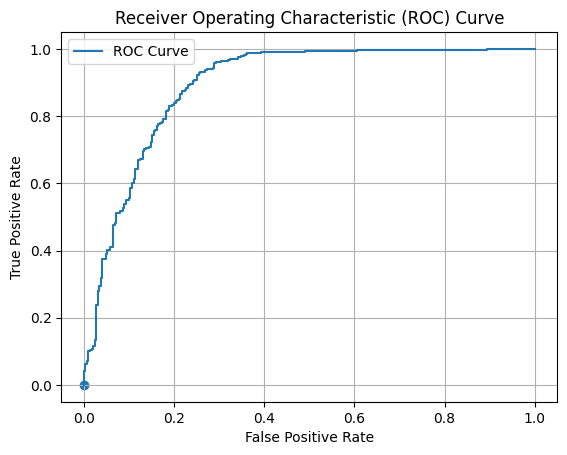

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
#-----------------------------------------------------------How the threshold value affects the ROC-----------------------------------------------------------------------------
threshold_values = [0.3, 0.4, 0.5, 0.6, 0.7] #Different threshold values
best_score = 0 

for threshold in threshold_values: 
    predicted_logreg_threshold = (logreg_grid_pred[:, 1] >= threshold).astype(int) #creats boolean array and converts it to 0 or 1 
    logreg_score = accuracy_score(y_test, predicted_logreg_threshold) #takes the ROC score for the different thresholds
    if logreg_score > best_score: #if the ROC score is better than best_score, replace
        best_score = logreg_score
        best_threshold = threshold

# Use the best threshold for predictions on the test data
logreg_grid_pred_test = best_logreg_model.predict_proba(X_test)
pred_logreg_grid_test = (logreg_grid_pred_test[:, 1] >= best_threshold).astype(int)
acc_logreg_grid_test = np.mean(pred_logreg_grid_test == y_test)
auc_score_logreg = roc_auc_score(y_test, predicted_logreg_threshold)

print(f"Accuracy for logistic regression model on test set with best threshold: {acc_logreg_grid_test:.3f}")
print(f"Confusion matrix for best model :\n{pd.crosstab(pred_logreg_grid_test, y_test)}\n")
print(f"Best threshold found on validation set: {best_threshold}")
print(f"AUC Score: {auc_score_logreg:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, logreg_grid_pred_test[:, 1]) #takes the false and negative positive and rate

best_threshold_index = np.argmax(thresholds >= best_threshold)

#ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()



# K-NN without grid search

In [ ]:
#k-nn for one value
model = skl_nb.KNeighborsClassifier(n_neighbors=36)
model.fit(X_train, y_train)

# Ensure X_test is a NumPy array or DataFrame
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

prediction = model.predict(X_test_array)
print('Confusion matrix:\n')
print(pd.crosstab(prediction, y_test), '\n')
print(f"Accuracy:{np.mean(prediction == y_test):.3f}")

Confusion matrix:

heard    0    1
row_0          
0       76   24
1      214  828 

Accuracy:0.792


/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#Different values of n without gridsearch

best_accuracy = 0
best_k = 0
best_conf_matrix = None

k_values = list(range(1, 201))
missclassification_rates = []

for k in k_values:
    model = skl_nb.KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    # Ensure X_test is a NumPy array or DataFrame
    X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

    prediction = model.predict(X_test_array)

    accuracy = np.mean(prediction == y_test)
    missclassification_rates.append(np.mean(prediction != y_test))

    # Update best results if needed
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        best_conf_matrix = pd.crosstab(prediction, y_test)


# Print the best results
print(f"Best k: {best_k}")
print(f"Best Accuracy: {best_accuracy:.3f}")
print("Best Confusion Matrix:")
print(best_conf_matrix)


/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifi

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifi

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifi

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifi

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifi

Best k: 5
Best Accuracy: 0.832
Best Confusion Matrix:
heard    0    1
row_0          
0      139   41
1      151  811


/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


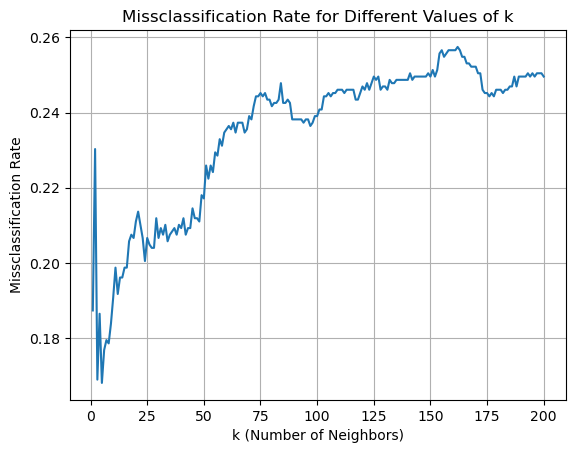

In [ ]:
# Plotting the missclassification rate

plt.plot(k_values, missclassification_rates, linestyle='-')
plt.title('Missclassification Rate for Different Values of k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Missclassification Rate')
plt.grid(True)

plt.show()

# K-NN with grid search (use this)

In [ ]:
# Different values of n with gridseach

# Create a pipeline with scaling and KNN
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Define hyperparameters to search
param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 201)),
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'kneighborsclassifier__weights': ['uniform', 'distance']  
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Get the best k value and weights
best_k = grid_search.best_params_['kneighborsclassifier__n_neighbors']
best_metric = grid_search.best_params_['kneighborsclassifier__metric']
best_weights = grid_search.best_params_['kneighborsclassifier__weights']

# Predictions on the test set
test_predictions = best_model.predict(X_test)

# Compute F1-score and balanced accuracy
f1 = f1_score(y_test, test_predictions)
balanced_acc = balanced_accuracy_score(y_test, test_predictions)

# Compute precision and recall
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)


# Predictions on the test set
test_predictions = best_model.predict(X_test)

# Print confusion matrix, accuracy, best k, best metric, and best weights
print(f"Best k Value: {best_k}")
print(f"Best Metric: {best_metric}")
print(f"Best Weights: {best_weights}")
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, test_predictions))
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("F1-score:", f1)
print("Balanced Accuracy:", balanced_acc)
print("Precision:", precision)
print("Recall:", recall)
print("Best Parameters:", grid_search.best_params_)


Best k Value: 36
Best Metric: euclidean
Best Weights: distance
Confusion Matrix (Test Set):
 [[222  68]
 [ 41 811]]
Test Accuracy: 0.9045534150612959
F1-score: 0.9370306181398036
Balanced Accuracy: 0.8586975878258054
Precision: 0.9226393629124005
Recall: 0.9518779342723005
Best Parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 36, 'kneighborsclassifier__weights': 'distance'}


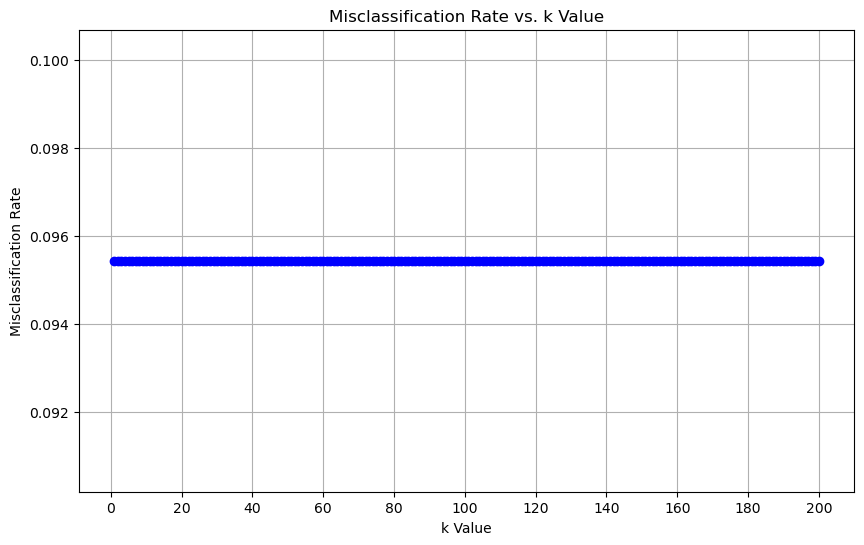

In [ ]:
#plot misclassification rate, a bit unnecessary but plotted it with manual before as well
# Lists to store results
missclassification_rates = []
k_values = []

# Perform grid search with cross-validation
for k in range(1, 201):
    # Use the best_model for predictions
    prediction = best_model.predict(X_test)
    missclassification_rate = np.mean(prediction != y_test)
    missclassification_rates.append(missclassification_rate)
    k_values.append(k)

# Plot misclassification rate
plt.figure(figsize=(10, 6))
plt.plot(k_values, missclassification_rates, marker='o', linestyle='-', color='b')
plt.title('Misclassification Rate vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Misclassification Rate')
plt.xticks(range(0, 201, 20))
plt.grid(True)
plt.show()


# LDA and QDA

### LDA - best performing

In the other jupyterfile, I've explored which features increase accuracy. 
Some highlights is that "age" negatively affects accuracy when we have age groups
However "dist" positively affect accuracy when we have distance groups
Distance groups increase accuracy a little bit for some cases, that's why I'm keeping them
Features related to coordinates, suchb as xcoord, ycoord, near_x, near_y and near_angle do not affect accuracy, hence removal for simplicity
Multiple age groups (agegroup1) performs better than only have 3 age group buckets (agegroup2). 
Having both agegroup1 and agegroup2 togheter gives no effect


In [ ]:
#X_train.columns

In [ ]:
#columns_to_remove = ['age']
columns_to_remove = ['age_group2_Young','age_group2_Middle-aged', 'age_group2_Elderly','age']

#Let these be
X_train_lda= X_train.copy().drop(columns=columns_to_remove, axis=1)
y_train = train['heard']
#print(current_X_train)

X_test_lda = X_test.copy().drop(columns=columns_to_remove, axis=1)
y_test = test['heard']

In [ ]:
#Checking VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_train_QDA is your training data

# Calculate VIF for each predictor variable
vif_data = X_train_lda.copy()
vif_data['Intercept'] = 1  # Adding an intercept column for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                     Variable          VIF
0                    near_fid     1.340133
1                      near_x   537.640213
2                      near_y  1657.904824
3                  near_angle     1.068304
4                    building     1.155975
5                       xcoor   532.352372
6                       ycoor  1657.754146
7                       noise          inf
8                  in_vehicle          inf
9                      asleep     1.025377
10                 no_windows     1.104902
11                       dist     2.460112
12           noise_in_vehicle          inf
13       noise_not_in_vehicle          inf
14       not_noise_in_vehicle          inf
15   not_noise_not_in_vehicle          inf
16            age_group1_0-39          inf
17           age_group1_40-49          inf
18           age_group1_50-59          inf
19           age_group1_60-69          inf
20             age_group1_70+          inf
21      distance_groups_0-500          inf
22   distan

/Users/Elise/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [ ]:


#LDA
lda_model = skl_da.LinearDiscriminantAnalysis()
lda_model.fit(X_train_lda, y_train)

#Predict
predict_prob_lda = lda_model.predict_proba(X_test_lda)

print("The class order in the model: ")
print(lda_model.classes_)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(predict_prob_lda[0:5])

prediction_lda = np.empty(len(X_test_lda), dtype=object)
prediction_lda = np.where(predict_prob_lda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(prediction_lda[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(prediction_lda == y_test):.3f}")

The class order in the model: 
[0 1]
Examples of predicted probabilities for the above classes: 
[[0.999463 0.000537]
 [0.00034  0.99966 ]
 [0.049516 0.950484]
 [0.896767 0.103233]
 [0.012047 0.987953]]
Five first predictions: 
[0 1 1 0 1] 

Confusion matrix: 

heard    0    1
row_0          
0      234   29
1       56  823 

Accuracy: 0.926


In [ ]:
#LDA with grid

# Define hyperparameters grid
#param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              #'shrinkage': [None, 'auto', 0.1, 0.5],
              #'n_components': [None] + list(range(1, min(X_train_lda.shape[1], len(np.unique(y_train))))),
             #}

lda_model = skl_da.LinearDiscriminantAnalysis()

pipeline = make_pipeline(StandardScaler(), qda_model)

param_grid = {
    'solver': ['svd', 'lsqr'], # eigen solver fails
    'n_components': [None] + list(range(1, min(X_train_lda.shape[1], len(np.unique(y_train))))),
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lda_model, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train_lda, y_train)

# Get the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Use the best model obtained from grid search
best_lda_model = grid_search.best_estimator_

# Predict on the testing dataset
prediction_lda = best_lda_model.predict(X_test_lda)

# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")

# Accuracy
print(f"Accuracy: {np.mean(prediction_lda == y_test):.3f}")

Best hyperparameters: {'n_components': None, 'solver': 'svd'}
Best CV accuracy: 0.9179064377661831
Confusion matrix: 

heard    0    1
row_0          
0      234   29
1       56  823 

Accuracy: 0.926


In [ ]:
#LDA with StandardScaler and GridSearch
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import numpy as np

# Create a pipeline with StandardScaler and LDA
pipeline = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

# Define hyperparameters grid for LDA
param_grid = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
}

# Perform grid search with cross-validation
grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search_lda.fit(X_train_lda, y_train)

# Get the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search_lda.best_params_)
print("Best CV accuracy:", grid_search_lda.best_score_)

# Use the best model obtained from grid search
best_lda_model = grid_search_lda.best_estimator_

# Predict on the testing dataset
prediction_lda = best_lda_model.predict(X_test_lda)

# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")

# Accuracy
print(f"Accuracy: {np.mean(prediction_lda == y_test):.3f}")


Best hyperparameters: {'lineardiscriminantanalysis__solver': 'svd'}
Best CV accuracy: 0.9179064377661831
Confusion matrix: 

heard    0    1
row_0          
0      234   29
1       56  823 

Accuracy: 0.926


### LDA Result

so best accuracy for LDA is 92.6%

In [ ]:
# LDA with SMOTE, standardscaler and gridsearch

from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE()

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_lda, y_train)


# Create a pipeline with StandardScaler and LDA
pipeline = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

# Define hyperparameters grid for LDA
param_grid = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
}

# Perform grid search with cross-validation
grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search_lda.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search_lda.best_params_)
print("Best CV accuracy:", grid_search_lda.best_score_)

# Use the best model obtained from grid search
best_lda_model = grid_search_lda.best_estimator_

# Predict on the testing dataset
prediction_lda = best_lda_model.predict(X_test_lda)

# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")

# Accuracy
print(f"Accuracy: {np.mean(prediction_lda == y_test):.3f}")

Best hyperparameters: {'lineardiscriminantanalysis__solver': 'svd'}
Best CV accuracy: 0.9226045742572223
Confusion matrix: 

heard    0    1
row_0          
0      233   29
1       57  823 

Accuracy: 0.925


In [194]:
#columns_to_remove = ['age']
columns_to_remove = ['age_group2_Young','age_group2_Middle-aged', 'age_group2_Elderly','age']

#Let these be
X_train_lda= X_train.copy().drop(columns=columns_to_remove, axis=1)
y_train = train['heard']
#print(current_X_train)

X_test_lda = X_test.copy().drop(columns=columns_to_remove, axis=1)
y_test = test['heard']

In [195]:
X_train_lda.columns

Index(['near_fid', 'near_x', 'near_y', 'near_angle', 'building', 'xcoor',
       'ycoor', 'noise', 'in_vehicle', 'asleep', 'no_windows', 'dist',
       'noise_in_vehicle', 'noise_not_in_vehicle', 'not_noise_in_vehicle',
       'not_noise_not_in_vehicle', 'age_group1_0-39', 'age_group1_40-49',
       'age_group1_50-59', 'age_group1_60-69', 'age_group1_70+',
       'distance_groups_0-500', 'distance_groups_500-1000',
       'distance_groups_1000-1500', 'distance_groups_1500-2000',
       'distance_groups_2000-2500', 'distance_groups_2500-3000',
       'distance_groups_>3000'],
      dtype='object')

In [196]:
# LDA with SMOTE, standardscaler and gridsearch



from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE()

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_lda, y_train)


# Create a pipeline with StandardScaler and LDA
pipeline = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

# Define hyperparameters grid for LDA
param_grid = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr'],  # solver options for LDA
}

# Perform grid search with cross-validation
grid_search_lda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search_lda.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search_lda.best_params_)
print("Best CV accuracy:", grid_search_lda.best_score_)

# Use the best model obtained from grid search
best_lda_model = grid_search_lda.best_estimator_

# Predict on the testing dataset
prediction_lda = best_lda_model.predict(X_test_lda)

# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_lda, y_test), "\n")

# Accuracy
print(f"Accuracy: {np.mean(prediction_lda == y_test):.3f}")

Best hyperparameters: {'lineardiscriminantanalysis__solver': 'svd'}
Best CV accuracy: 0.924468476240359
Confusion matrix: 

heard    0    1
row_0          
0      232   29
1       58  823 

Accuracy: 0.924


### QDA

###  add this info to the report: https://stats.stackexchange.com/questions/29385/collinear-variables-in-multiclass-lda-training

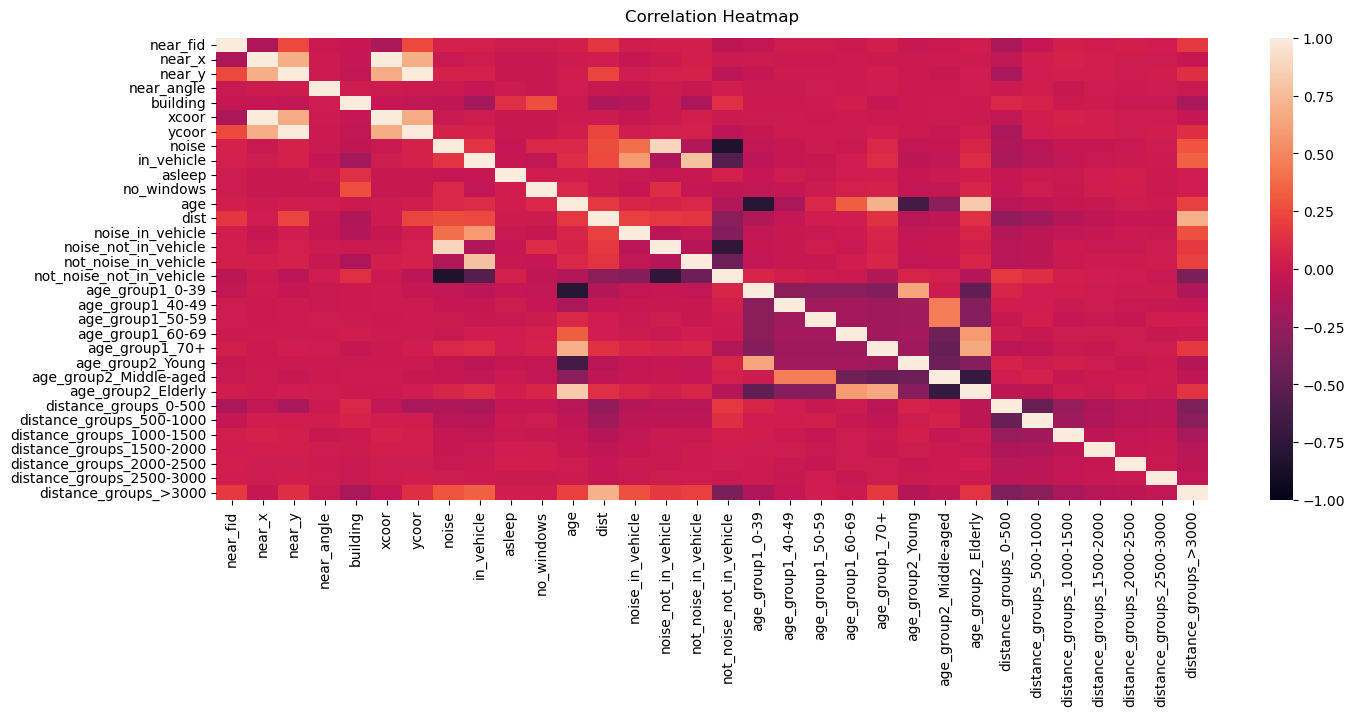

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=False)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
columns_to_remove = ['noise_in_vehicle', 'noise_not_in_vehicle', 'not_noise_in_vehicle',
       'not_noise_not_in_vehicle', 'distance_groups_0-500', 'distance_groups_500-1000',
       'distance_groups_1000-1500', 'distance_groups_1500-2000',
       'distance_groups_2000-2500', 'distance_groups_2500-3000',
       'distance_groups_>3000', 'age_group1_0-39', 'age_group1_40-49', 'age_group1_50-59',
       'age_group1_60-69', 'age_group1_70+' , 'age_group2_Young', 'age_group2_Middle-aged',
       'age_group2_Elderly', 'near_fid', 'asleep']
X_train_QDA = X_train.drop(columns=columns_to_remove , axis=1)
X_test_QDA = X_test.drop(columns=columns_to_remove , axis=1)

In [ ]:
#Checking VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X_train_QDA is your training data

# Calculate VIF for each predictor variable
vif_data = X_train_QDA.copy()
vif_data['Intercept'] = 1  # Adding an intercept column for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif)

      Variable          VIF
0       near_x   515.263207
1       near_y  1650.626772
2   near_angle     1.066407
3     building     1.125432
4        xcoor   512.118236
5        ycoor  1650.935435
6        noise     1.091622
7   in_vehicle     1.106862
8   no_windows     1.096209
9          age     1.047995
10        dist     1.404356
11   Intercept   303.595850


In [ ]:
#X_train_QDA.columns

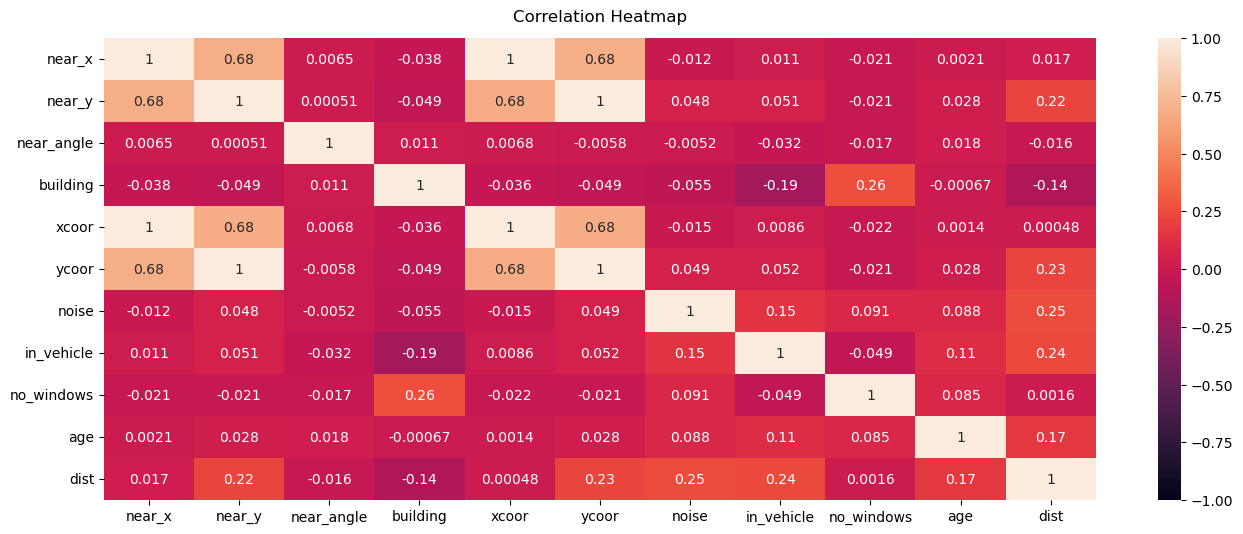

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(X_train_QDA.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
qda_model = skl_da.QuadraticDiscriminantAnalysis()
qda_model.fit(X_train_QDA, y_train)

predict_prob_qda = qda_model.predict_proba(X_test_QDA)

print("The class order in the model: ")
print(qda_model.classes_)

print("Examples of predicted probabilities for the above classes: ")
with np.printoptions(suppress=True, precision=6):
    print(predict_prob_qda[0:5])

prediction_qda = np.empty(len(X_test_QDA), dtype=object)
prediction_qda = np.where(predict_prob_qda[:, 0] >= 0.5, 0, 1) #0 is not heard, 1 is heard
print("Five first predictions: ")
print(prediction_qda[0:5], "\n")


# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_qda, y_test), "\n")

#Accuracy
print(f"Accuracy: {np.mean(prediction_qda == y_test):.3f}")

The class order in the model: 
[0 1]
Examples of predicted probabilities for the above classes: 
[[1.       0.      ]
 [0.000001 0.999999]
 [0.000706 0.999294]
 [0.999984 0.000016]
 [0.000014 0.999986]]
Five first predictions: 
[0 1 1 0 1] 

Confusion matrix: 

heard    0    1
row_0          
0      218   38
1       72  814 

Accuracy: 0.904


In [ ]:
#QDA with grid

qda_model = skl_da.QuadraticDiscriminantAnalysis()
#qda_model.fit(X_train_QDA, y_train)



#pipeline = make_pipeline(StandardScaler(), qda_model)

# Define hyperparameters grid for QDA
param_grid = {
    'reg_param': [0.0, 0.1, 0.5, 1.0]  # Regularization parameter
}

# Perform grid search with cross-validation
grid_search_qda = GridSearchCV(estimator=qda_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_qda.fit(X_train_QDA, y_train)

# Get the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search_qda.best_params_)
print("Best CV accuracy:", grid_search_qda.best_score_)

# Use the best model obtained from grid search
best_qda_model = grid_search_qda.best_estimator_

# Predict on the testing dataset
prediction_qda = best_qda_model.predict(X_test_QDA)

# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_qda, y_test), "\n")

# Accuracy
print(f"Accuracy: {np.mean(prediction_qda == y_test):.3f}")

Best hyperparameters: {'reg_param': 0.0}
Best CV accuracy: 0.9100244223362516
Confusion matrix: 

heard    0    1
row_0          
0      218   38
1       72  814 

Accuracy: 0.904


In [ ]:
#QDA with grid and standardscaler

# Create a pipeline with StandardScaler and QDA
pipeline = make_pipeline(StandardScaler(), skl_da.QuadraticDiscriminantAnalysis())

# Define hyperparameters grid for QDA
param_grid = {
    'quadraticdiscriminantanalysis__reg_param': [0.0, 0.1, 0.5, 1.0]  # regularization parameter for QDA
}

# Perform grid search with cross-validation
grid_search_qda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_qda.fit(X_train_QDA, y_train)

# Get the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search_qda.best_params_)
print("Best CV accuracy:", grid_search_qda.best_score_)

# Use the best model obtained from grid search
best_qda_model = grid_search_qda.best_estimator_

# Predict on the testing dataset
prediction_qda = best_qda_model.predict(X_test_QDA)

# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_qda, y_test), "\n")

# Accuracy
print(f"Accuracy: {np.mean(prediction_qda == y_test):.3f}")

Best hyperparameters: {'quadraticdiscriminantanalysis__reg_param': 0.0}
Best CV accuracy: 0.9100244223362516
Confusion matrix: 

heard    0    1
row_0          
0      218   38
1       72  814 

Accuracy: 0.904


In [ ]:
pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 7.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# QDA with SMOTE, standardscaler and gridsearch

from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE()

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_QDA, y_train)


pipeline = make_pipeline(StandardScaler(), skl_da.QuadraticDiscriminantAnalysis())

# Define hyperparameters grid for QDA
param_grid = {
    'quadraticdiscriminantanalysis__reg_param': [0.0, 0.1, 0.5, 1.0]  # regularization parameter for QDA
}

# Perform grid search with cross-validation
grid_search_qda = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_qda.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search_qda.best_params_)
print("Best CV accuracy:", grid_search_qda.best_score_)

# Use the best model obtained from grid search
best_qda_model = grid_search_qda.best_estimator_

# Predict on the testing dataset
prediction_qda = best_qda_model.predict(X_test_QDA)

# Confusion matrix
print("Confusion matrix: \n")
print(pd.crosstab(prediction_qda, y_test), "\n")

# Accuracy
print(f"Accuracy: {np.mean(prediction_qda == y_test):.3f}")

Best hyperparameters: {'quadraticdiscriminantanalysis__reg_param': 0.0}
Best CV accuracy: 0.8144994916350864
Confusion matrix: 

heard    0    1
row_0          
0      223   40
1       67  812 

Accuracy: 0.906


### QDA result

So best accuracy I can perform for QDA is 90.4% accuracy.


#### Assessment

In [ ]:
def classification_report_interval(
    y_true,
    y_pred,
    labels=None,
    alpha = 0.01,
    union_bound_correction=True
):
    """Produces a classification report with precision, recall and accuracy
    It also uses Hoeffdings inequality to produce confidence intervals around
    each measurement. We can do this with or without multiple measurement
    correction (union bound correction).

    Example output is:
                labels           precision             recall

               0.0  0.88 : [0.50,1.00] 0.40 : [0.15,0.65]
               1.0  0.56 : [0.34,0.78] 0.93 : [0.65,1.00]

          accuracy                                        0.64 : [0.45,0.83]

    Parameters:
    y_true                          -- The true labels
    y_pred                          -- The predicted labels
    labels                          -- TODO
    alpha[0.01]                     -- The confidence level of the intervals
    union_bound_correction[True]    -- If we should compensate with the union bound because we
                                    have multiple intervals to compute in order to keep the level
                                    of confidence for all intervals jointly.

    Returns:
    a printable string.
    """
    import numpy as np

    def precision_recall(y_true,
        y_pred,
        labels=None,alpha=0.01, correction=1):
        p = []
        r = []
        f1 = []
        support = []
        for label in labels:
            y_true_pred_label = y_true[y_pred == label]
            precision = np.mean(y_true_pred_label == label)
            delta = (1/np.sqrt(len(y_true_pred_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            p.append("%.2f : [%.2f,%.2f]" % (precision, np.maximum(precision-delta,0),np.minimum(precision+delta,1)))

            y_pred_true_label = y_pred[y_true == label]
            recall = np.mean(y_pred_true_label == label)
            delta = (1/np.sqrt(len(y_pred_true_label)))*np.sqrt((1/2)*np.log(2*correction/alpha))
            r.append("%.2f : [%.2f,%.2f]" % (recall, np.maximum(recall-delta,0),np.minimum(recall+delta,1)))

        return (p,r)

    def accuracy_interval(y_true,y_pred,alpha=0.01,correction=1):
        acc = np.mean(y_true == y_pred)
        delta = (1/np.sqrt(len(y_true)))*np.sqrt((1/2)*np.log(2*correction/alpha))
        return "%.2f : [%.2f,%.2f]" % (acc, np.maximum(acc-delta,0),np.minimum(acc+delta,1))

    digits = 18
    target_names = None
    if labels is None:
        labels = list(set(y_true).union(set(y_pred)))
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall"]
    # compute per-class results without averaging
    # Simple correction using the union bound
    # We are computing 2 intervals for each label for precision and recall
    # In addition we are computing 2 intervals for accuracy
    # This is in total 2*n_labels+2
    if (union_bound_correction):
        correction = 2*len(labels)+2
    else:
        correction=1
    p, r = precision_recall(
        y_true,
        y_pred,
        labels=labels,
        alpha=alpha,
        correction=correction
    )

    rows = zip(target_names, p, r)

    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, digits)
    head_fmt = "{:>{width}s} " + " {:>{digits}}" * len(headers)
    report = head_fmt.format("labels", *headers, width=width,digits=digits)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>{digits}s}" * 2 + "\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    row_fmt_acc = "{:>{width}s} " + " {:>{digits}s}" * 2 + " {:>{digits}s}""\n"
    report += "\n"
    accuracy = accuracy_interval(y_true,y_pred,alpha=alpha,correction=correction)
    report+=row_fmt_acc.format(*("accuracy","","",accuracy),width=width,digits=digits)

    return report

In [ ]:
report_lda = classification_report_interval(
    y_test.values.reshape(-1),
    prediction_lda,
    alpha = 0.05,
)

print("Performance assessment LDA")
print("Confidence intervals are within brackets")
print(report_lda)

In [ ]:
labels = ["Not heard", "Heard"]
cm = confusion_matrix(y_test, prediction_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

In [ ]:
report_qda = classification_report_interval(
    y_test.values.reshape(-1),
    prediction_qda,
    alpha = 0.05,
)

print("Performance assessment QDA")
print("Confidence intervals are within brackets")
print(report_qda)

In [ ]:
labels = ["Not heard", "Heard"]
cm = confusion_matrix(y_test, prediction_qda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

# Extra, compare sampling methods

In [ ]:
#compare performances, stratified sampling is better for age group

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def split_comparison(data, target_column, test_size=0.2, random_state=None):
    # Original data overall performance
    overall_performance = data[target_column].value_counts(normalize=True)
    
    # Stratified Sampling
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, data[target_column]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    
    # Random Sampling
    rand_train_set, rand_test_set = train_test_split(data, test_size=test_size, random_state=random_state)
    
    # Calculate performance metrics for stratified sampling
    strat_train_performance = strat_train_set[target_column].value_counts(normalize=True)
    strat_test_performance = strat_test_set[target_column].value_counts(normalize=True)
    
    # Calculate performance metrics for random sampling
    rand_train_performance = rand_train_set[target_column].value_counts(normalize=True)
    rand_test_performance = rand_test_set[target_column].value_counts(normalize=True)
    
    # Calculate percentage error
    strat_train_error = ((strat_train_performance - overall_performance) / overall_performance) * 100
    strat_test_error = ((strat_test_performance - overall_performance) / overall_performance) * 100
    
    rand_train_error = ((rand_train_performance - overall_performance) / overall_performance) * 100
    rand_test_error = ((rand_test_performance - overall_performance) / overall_performance) * 100
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Overall performance': overall_performance,
        'Stratified': strat_test_performance,
        'Random': rand_test_performance,
        'Strat. % error': strat_test_error,
        'Rand. % error': rand_test_error
    })
    
    return comparison_df

# Example usage:
comparison_table = split_comparison(data, target_column='age', test_size=0.2, random_state=42)
print(comparison_table)
